In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os
import numpy as np


model = models.resnet18(pretrained=True)
model.eval()


feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Imagenet mean
        std=[0.229, 0.224, 0.225]    # Imagenet std
    )
])


def extract_vector(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        features = feature_extractor(img_tensor)
    return features.view(-1).cpu().numpy()  # Konversi ke shape (512,) dan NumPy array

img_path = "test.jpg"
vector = extract_vector(img_path)

print("Feature vector shape:", vector.shape)
print("Feature vector (first 10 values):", vector[:10])


Feature vector shape: (512,)
Feature vector (first 10 values): [0.13951726 0.06467745 0.32666507 0.39873013 0.5905248  0.08515333
 0.36760217 0.1113233  0.7910533  0.08511679]


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def load_image(path):
    img = Image.open(path).convert('RGB')
    img_array = np.asarray(img).astype(np.float32) / 255.0  # Normalisasi ke 0-1
    return img_array

img = load_image("test.jpg")

#Normalisasi ini penting supaya semua operasi selanjutnya bekerja konsisten dalam skala intensitas piksel yang sama (bukan 0–255 lagi).

In [ ]:
def adjust_brightness_linear(img, alpha=1.5, beta=0.1):
    return np.clip(alpha * img + beta, 0, 1)

    #Melakukan peningkatan kecarahan secara linear untuk membantu memperjelas
    #Detail di daerah gelap atau low-light

In [ ]:
#Untuk meningkatkan detail pad abagian gelap dengan transformasi logaritmik
def adjust_brightness_log(img):
    return np.log1p(img) / np.log1p(1.0)  # log(1 + I) dinormalisasi

    #Lebih cocok untuk menonjolkan detail halus di daerah gelap tanpa terlalu mencerahkan seluruh gambar.

In [ ]:
#Dilakukan histogram equalization untuk setiap channel warna
#Meningkatkan kontras gambar dengan meratakan distribusi histogram intensitas piksel pada masing-masing channel RGB.
#Supaya detail visual lebih tampak, terutama pada area gelap atau datar.
img_bright = adjust_brightness_linear(img)  # Atau bisa juga pakai log
img_eq = equalize_histogram(img_bright)x

def equalize_histogram(img):
    out = np.zeros_like(img)
    for channel in range(3):  # RGB
        flat = img[:, :, channel].flatten()
        hist, bins = np.histogram(flat, bins=256, range=[0,1])
        cdf = hist.cumsum()
        cdf = (cdf - cdf.min()) / (cdf.max() - cdf.min())
        out[:, :, channel] = cdf[(img[:, :, channel] * 255).astype(np.uint8)]
    return out

In [ ]:
img_eq = equalize_histogram(img_bright)

In [ ]:
#Membuat Karnel Gaussian untuk blur halus
#Digunakan untuk meredam noise (bintik-bintik kecil) dengan blur halus.
def gaussian_kernel(size=5, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

#Mengaplikasikan filter diatas ke gambar warna
#Digunakan untuk mengaburkan noise setelah kontras ditingkatkan, agar hasil lebih bersih.
def apply_filter(img, kernel):
    pad = kernel.shape[0] // 2
    img_padded = np.pad(img, ((pad, pad), (pad, pad), (0,0)), mode='reflect')
    output = np.zeros_like(img)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(3):
                region = img_padded[y:y+kernel.shape[0], x:x+kernel.shape[1], c]
                output[y, x, c] = np.sum(region * kernel)
    return np.clip(output, 0, 1)

In [ ]:
gauss_kernel = gaussian_kernel(size=5, sigma=1)
img_blur = apply_filter(img_eq, gauss_kernel)

In [ ]:
#Versi grayscale dari apply_filter, untuk gambar hitam putih
def apply_filter_gray(img, kernel):
    pad = kernel.shape[0] // 2
    img_padded = np.pad(img, ((pad, pad), (pad, pad)), mode='reflect')
    output = np.zeros_like(img)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            region = img_padded[y:y+kernel.shape[0], x:x+kernel.shape[1]]
            output[y, x] = np.sum(region * kernel)
    return np.clip(output, 0, 1)

In [ ]:
#Membuat karnel Laplacian untuk mendeteksi tepi gambar
#Deteksi perubahan mendadak intensitas piksel — inilah yang menandakan tepi objek.
def laplacian_filter():
    return np.array([[0, 1, 0],
                     [1, -4, 1],
                     [0, 1, 0]])


#Merubah gambar warna menjadi grayscale
#Operasi deteksi tepi biasanya lebih efektif di citra abu-abu.
def grayscale(img):
    return np.mean(img, axis=2)


#Menambahkan detail tepi kembali ke gambar asli sehingga gambar tampak lebih tajam.
#Setelah blur (reduksi noise), kita ingin menegaskan kembali tepi agar gambar tidak terlihat lembek atau kusam.
def sharpen_image(img):
    gray = grayscale(img)
    lap = apply_filter_gray(gray, laplacian_filter())
    sharp = gray - 0.3 * lap  # dari 0.7 menjadi 0.3 karena terlalu keras
    sharp = np.clip(sharp, 0, 1)
    return np.stack([sharp]*3, axis=2)  # kembalikan ke RGB 3 channel

In [ ]:
img_sharp = sharpen_image(img_blur)

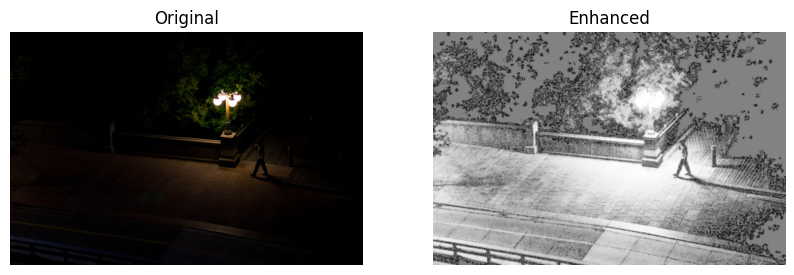

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Enhanced")
plt.imshow(img_sharp)
plt.axis('off')
plt.show()

In [ ]:
def laplacian_filter():
    return np.array([[0,  1, 0],
                     [1, -4, 1],
                     [0,  1, 0]])

def apply_filter_gray(img, kernel):
    pad = kernel.shape[0] // 2
    img_padded = np.pad(img, ((pad, pad), (pad, pad)), mode='reflect')
    output = np.zeros_like(img)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            region = img_padded[y:y+kernel.shape[0], x:x+kernel.shape[1]]
            output[y, x] = np.sum(region * kernel)
    return np.clip(output, 0, 1)

def grayscale(img):
    return np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])

def sharpen_image_color(img):
    gray = grayscale(img)
    lap = apply_filter_gray(gray, laplacian_filter())
    sharpened = img - 0.3 * np.stack([lap]*3, axis=2)
    return np.clip(sharpened, 0, 1)

In [ ]:
def normalize(img):
    return img / 255.0

def adjust_brightness(img, factor=1.5):
    return np.clip(img * factor, 0, 1)

def histogram_equalization_channel(channel):
    hist, bins = np.histogram(channel.flatten(), 256, [0, 1])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf[-1]
    eq = np.interp(channel.flatten(), bins[:-1], cdf_normalized)
    return eq.reshape(channel.shape)

def enhance_contrast(img):
    # Equalisasi tiap channel warna (bukan grayscale)
    channels = []
    for i in range(3):
        ch_eq = histogram_equalization_channel(img[:, :, i])
        channels.append(ch_eq)
    return np.stack(channels, axis=2)

def enhance_image_pipeline(img):
    img = normalize(img) #Supaya semua operasi (seperti brightness, konvolusi) dilakukan dalam rentang 0–1.
    img_bright = adjust_brightness(img, factor=1.8)
    img_contrast = enhance_contrast(img_bright)
    img_sharp = sharpen_image_color(img_contrast)
    return np.clip(img_sharp, 0, 1)

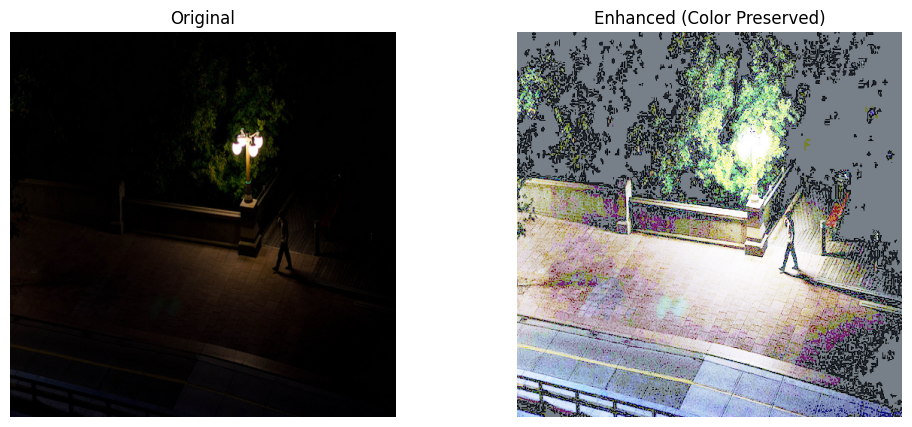

In [ ]:
enhanced_img = enhance_image_pipeline(img_np)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_np / 255.0)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(enhanced_img)
plt.title("Enhanced (Color Preserved)")
plt.axis("off")
plt.show()